### Prelimenary Analysis of Outbound Requests from News Sites

> the aim of this notebooks is to perform a basic analysis of new sites and the outbound requests captured while on their page

__content__:

- `All Relationships`
    - this is a view of the entire data set.
    - news sites have been color coded and all outbound requests are black

- `Filtered Relationships`
    - addition of  `get_subgraph()`
    - access individual node views
    - access multiple node views
        - illuminate shared pairwise relations
    - addition of `calculate_difference()`
    - analysis of common neighbors and shared connectivity

- `Centrality`
    - centrailty is defined as: the node with the most connections in a give graph
    - analysis of degree centrality can tell us about distributions of signals via requests and message routing.
        

    

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from utils.graph import Graph_Viz_Engine
from utils.io import read_in

In [2]:
# pull in the data and place it into a graph data structure
page_relations = './data/outbound-requests-by-domain.json'
relations = read_in(page_relations)
G = nx.Graph(relations)
pos = nx.spring_layout(G)

In [7]:
def generate_node_color_map(nodes: list) -> dict:
    """
    function to map colors to chosen nodes
    """
    c_map = clr.CSS4_COLORS
    colors = list(c_map.keys())

    return {node: c_map[colors[idx+10]] for idx, node in enumerate(nodes)}

cmap = generate_node_color_map(nodes=list(relations.keys()))

#### All Relationships
---

In [21]:
# instantiate graph engine and visualize
# visualization of entire dataset
engine = Graph_Viz_Engine(
    graph=G,
    pos=pos,
    node_cmap=cmap
)
engine.fig.show()

#### Filtered Relationships
---

In [49]:
def get_subgraph(G: nx.Graph, sub_nodes: list) -> tuple:

    """
    function to filter on sub_nodes to generate a sub_graph

    returns the graph structure and plot positions 
    """

    if len(sub_nodes) == 1:
        node = sub_nodes[0]
        graph = nx.ego_graph(G, node)

    else:
        graph = nx.edge_subgraph(G, nx.edges(G, sub_nodes))

    pos = nx.spring_layout(graph) # <-- needed for visualization

    return graph, pos

In [56]:
# give an outbound request
# get a list of all news sites it came from (that share it)
outbound_request = 'pixel.quantserve.com'
list(G.neighbors(outbound_request))


['www.politico.com',
 'www.thedailybeast.com',
 'news.vice.com/en_us',
 'apnews.com/',
 'www.motherjones.com',
 'theweek.com',
 'www.buzzfeednews.com',
 'www.nationalreview.com']

In [57]:
# visualize the outbound requests's ego graph
g, p = get_subgraph(G=G, sub_nodes=[outbound_request])
e = Graph_Viz_Engine(
    graph=g,
    pos=p,
    node_cmap=cmap
)
e.fig.show()

In [51]:
# give a news site
# get all outbound requests
newsite = 'nytimes.com'
list(G.neighbors(newsite))

['g1.nyt.com',
 'www.nytimes.com',
 'static01.nyt.com',
 'www.googletagmanager.com',
 'a.et.nytimes.com',
 'samizdat-graphql.nytimes.com',
 'als-svc.nytimes.com',
 'rumcdn.geoedge.be',
 'c.amazon-adsystem.com',
 'securepubads.g.doubleclick.net',
 'nytimes-d.openx.net',
 'fastlane.rubiconproject.com',
 'prebid.media.net',
 'ib.adnxs.com',
 'tlx.3lift.com',
 's.amazon-adsystem.com',
 'sb.scorecardresearch.com',
 'dd.nytimes.com',
 'meter-svc.nytimes.com',
 'content.api.nytimes.com',
 'purr.nytimes.com',
 'a.nytimes.com',
 'adservice.google.com',
 'mwcm.nytimes.com',
 'www.google-analytics.com',
 'tags.bluekai.com',
 '5290727.fls.doubleclick.net',
 'static.chartbeat.com',
 'tags.bkrtx.com',
 'a1.nyt.com',
 'cdn.brandmetrics.com',
 'insight.adsrvr.org',
 '52699c9a8373e35393f2c392f653289f.safeframe.googlesyndication.com',
 'stags.bluekai.com',
 'pnytimes.chartbeat.net',
 'eb2.3lift.com',
 'cs.media.net',
 'dis.criteo.com',
 'medianet-match.dotomi.com',
 'pm.w55c.net',
 'u.openx.net',
 'x.bi

In [54]:
# visualize news site's ego graph
g, p = get_subgraph(G=G, sub_nodes=[newsite])
e = Graph_Viz_Engine(
    graph=g,
    pos=p,
    node_cmap=cmap
)
e.fig.show()

##### SubGraph

in this below subgraph, we filter on a list of nodes to examine their common and non edge neighbors

In [50]:
# choose the news sites you want to analyze
sub_nodes = [
    'nytimes.com',
    'thehill.com',
    'www.latimes.com'
]
sub_g, sub_pos = get_subgraph(G=G, sub_nodes=sub_nodes)
sub_engine = Graph_Viz_Engine(
    graph=sub_g,
    pos=sub_pos,
    node_cmap=cmap
)
sub_engine.fig.show()

In [93]:

def _calculate_differences(
    
    G: nx.Graph, 
    node_1: str, 
    node_2: str, 
    diffs: dict
    
    ) -> dict:

    common = list(nx.common_neighbors(G, node_1, node_2))
    n1 = list(G.neighbors(node_1))
    n2 = list(G.neighbors(node_2))

    diffs[(node_1, node_2)] = {}
    diffs[(node_1, node_2)]['common'] = common
    diffs[(node_1, node_2)][node_1] = n1
    diffs[(node_1, node_2)][node_2] = n2

    diffs[(node_1, node_2)][f"{node_1} stats"] = {

        'total': len(n1),
        'shared': len(common),
        'shared_percent': round(len(common)/len(n1), 2)*100


    }
    diffs[(node_1, node_2)][f"{node_2} stats"] = {

        'total': len(n2),
        'shared': len(common),
        'shared_percent': round(len(common)/len(n2), 2)*100
    }

    return diffs    


 
def calculate_differences(
    
    G: nx.Graph, 
    sub_nodes: list
    
    ) -> dict:

    diffs = {}

    if len(sub_nodes) > 2:

        for idx, node in enumerate(sub_nodes):

            if idx + 1 == len(sub_nodes):
                return diffs

            node_1 = sub_nodes[idx]
            node_2 = sub_nodes[idx + 1]

            diff = calculate_differences(
                G=G, 
                sub_nodes=[
                    node_1, 
                    node_2
                ]
            )
            diffs.update(diff)

    else:

        return _calculate_differences(
            
            G=G, 
            node_1=sub_nodes[0], 
            node_2=sub_nodes[1], 
            diffs=diffs
            
        )



differences = calculate_differences(G, sub_nodes=['nytimes.com', 'thehill.com', 'www.latimes.com'])

In [102]:
# this shows the number of outbound requests shared between two sites, respectively node_1 and node_2
# then shows the percentange of their connectivity that is shared with the other node
node_1 = 'nytimes.com'
node_2 = 'thehill.com'
print(differences[(node_1, node_2)][f'{node_2} stats'])
print(differences[(node_1, node_2)][f'{node_1} stats'])

{'total': 60, 'shared': 13, 'shared_percent': 22.0}
{'total': 47, 'shared': 13, 'shared_percent': 28.000000000000004}


#### Degree Centrality and Analysis
---

In [38]:
def most_central(G: nx.Graph, top: int = 10) -> list:
    return [site for site, degree in sorted(list(G.degree), key=lambda x: x[1], reverse=True)[:top]]

In [39]:
# this function looks at the top ten 'highly connected' sites
most_central(G=G, top=10)

['www.nationalreview.com',
 'time.com/',
 'www.nydailynews.com',
 'apnews.com/',
 'www.cnn.com/us',
 'nymag.com',
 'www.bloomberg.com',
 'www.latimes.com',
 'news.vice.com/en_us',
 'nypost.com']

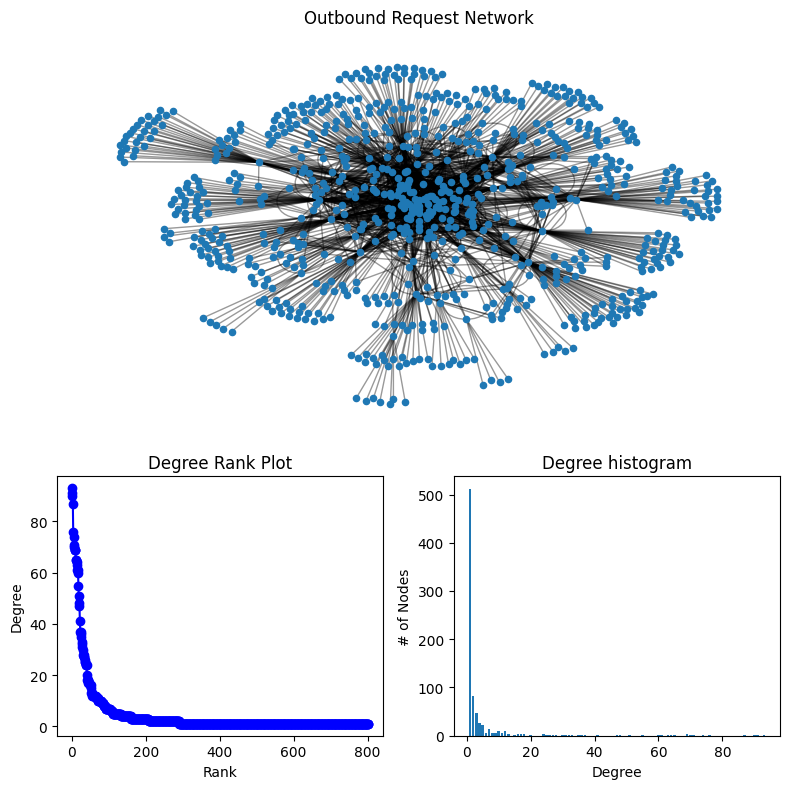

In [101]:
"""
the graph below is not interactive
it shows three views:
    1. full network of all relations
    2. rank by degree (most connected's value)
    3. distribution of connections (likelyhood of a given node's number of connections)
"""
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=12)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Outbound Request Network")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

#### Degree Analysis:
---

we can see that this graph has a centralized connectivity distrubution to small a percent of nodes which have over 80 connections. We can then see a binning of roughly 10% into the dominant holders of connections, leaving the remaining 90% with 20 or less connections, which is, at most, 1/8th of what the top 1% of the 10% hold.

before that can be too meaningful though, more details about each outbound request needs to be shown 